In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import entropy
from math import log, e

In [2]:
### RAW DATA FOR METADATA 

# #homePC
# results_file ='C:/Users/Sruthi Sivakumar/OneDrive - University of Pittsburgh/PhD proposal/Noisy channel research/files_from_box/tabula-muris-senis-facs-processed-official-annotations-Limb_Muscle.h5ad'
# # #results_file ='C:/Users/Sruthi Sivakumar/Box/Pitt/Tabula Muris senis- for proposal/processed h5ad files-figshare/tabula-muris-senis-facs-processed-official-annotations-Limb_Muscle.h5ad'

#labPC
results_file ='D:/OneDrive - University of Pittsburgh/PhD proposal/Noisy channel research/files_from_box/tabula-muris-senis-facs-processed-official-annotations-Limb_Muscle.h5ad'

adata = sc.read_h5ad(results_file)

### TMS single FACS data - clean gene counts data
### male and female mixed
### eliminated genes - which did not satisfy: expressed non-zero value in minimum of 10 cells 
### This is so that we consider genes that are expressed in a variety of cells

# #HOMEpc
# file='C:/Users/Sruthi Sivakumar/OneDrive - University of Pittsburgh/PhD proposal/Noisy channel research/nonzero_10cutoff_facscountmatrix8dec.csv'

#labPC
file='D:/OneDrive - University of Pittsburgh/PhD proposal/Noisy channel research/nonzero_10cutoff_facscountmatrix8dec.csv'

adata_facs_df= pd.read_csv(file,index_col=0)

C:\Users\SRS204\Anaconda3\lib\site-packages\anndata\compat\__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
C:\Users\SRS204\Anaconda3\lib\site-packages\anndata\compat\__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
# #homePC
# alltfdf=pd.read_csv("C:/Users/Sruthi Sivakumar/OneDrive - University of Pittsburgh/PhD proposal/Noisy channel research/files_from_box/trrust_rawdata.mouse_wheader.csv")

#labPC
alltfdf=pd.read_csv("D:/OneDrive - University of Pittsburgh/PhD proposal/Noisy channel research/files_from_box/trrust_rawdata.mouse_wheader.csv")


In [4]:
# raw single cell data - number of genes
print("Raw data number of genes", adata.var.shape)

# clean single cell data - number of genes
print("Clean data number of genes", adata_facs_df.shape)
adata_facs_df.head()

Raw data number of genes (22966, 5)
Clean data number of genes (3855, 10837)


,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,...,Zufsp,Zw10,Zwint,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,age,celltype
18m,0.0,0.000000,0.0,0.0,0.0,0.0,0.334001,0.037076,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.04276,0.000000,0.000000,0.153797,18m,skeletal muscle satellite cell
18m,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,2.299186,0.0,0.0,...,0.0,0.0,0.000000,6.599676,0.00000,2.941003,0.000000,0.000000,18m,skeletal muscle satellite cell
18m,0.0,0.072408,0.0,0.0,0.0,0.0,0.000000,2.137391,0.0,0.0,...,0.0,0.0,0.038261,0.046321,0.00000,2.052351,0.000000,0.000000,18m,skeletal muscle satellite cell
18m,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.00000,0.140650,0.000000,0.000000,18m,skeletal muscle satellite cell
18m,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.00000,0.599470,0.053462,0.000000,18m,skeletal muscle satellite cell


In [5]:
sc_facs=adata_facs_df

sc_facs.index=list(adata.obs.index.values)
#sc_facs.columns=list(adata.var.index.values)

sc_facs['age']=list(adata.obs.age)
sc_facs['animal_id']=list(adata.obs['mouse.id'])
sc_facs['celltype']=list(adata.obs.cell_ontology_class)
sc_facs['sex']=list(adata.obs.sex)

age3m_df=sc_facs[sc_facs['age']=='3m']
age18m_df=sc_facs[sc_facs['age']=='18m']
age24m_df=sc_facs[sc_facs['age']=='24m']

In [6]:
unique_dict={}
test_list=dict(zip(list(alltfdf['TF genes']),list(alltfdf['Non-TF genes'])))
for item in test_list.items():
    if item not in unique_dict:
        unique_dict.update({item})
    

len(unique_dict) 

827

In [7]:
age3m = age3m_df.drop(['age','celltype'], axis=1)
age3m_mean= age3m.mean(axis = 0, skipna = True)
age3m_mean_animal=age3m.groupby('animal_id').mean()
age3m= age3m.sum(axis = 0, skipna = True)


age18m = age18m_df.drop(['age','celltype'], axis=1)
age18m_mean= age18m_df.mean(axis = 0, skipna = True)
age18m_mean_animal=age18m.groupby('animal_id').mean()
age18m= age18m.sum(axis = 0, skipna = True)


age24m = age24m_df.drop(['age','celltype'], axis=1)
age24m_mean= age24m.mean(axis = 0, skipna = True)
age24m_mean_animal=age24m.groupby('animal_id').mean()
age24m= age24m.sum(axis = 0, skipna = True)

In [8]:
allcells_df=pd.concat([age3m_df,age18m_df,age24m_df])

In [9]:
allcells_df.head()

,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,...,Zwint,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,age,celltype,animal_id,sex
A1.B002765.3_38_F.1.1-1-1,1.761105,1.541098,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,1.522642,0.0,0.000000,1.806709,0.000000,0.000000,3m,skeletal muscle satellite cell,3_38_F,female
A1.D042103.3_11_M.1-1-1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3m,skeletal muscle satellite cell,3_11_M,male
A1.D042186.3_8_M.1.1-1-1,0.000000,1.788955,0.0,0.0,0.0,0.0,0.000000,0.384158,0.0,0.000000,...,0.000000,0.0,0.161871,1.352870,1.701163,0.289918,3m,skeletal muscle satellite cell,3_8_M,male
A10.B002765.3_38_F.1.1-1-1,0.000000,3.050025,0.0,0.0,0.0,0.0,0.000000,1.533476,0.0,0.000000,...,0.025267,0.0,0.000000,0.000000,0.000000,0.000000,3m,skeletal muscle satellite cell,3_38_F,female
A10.B002769.3_39_F.1.1-1-1,1.564775,0.000000,0.0,0.0,0.0,0.0,2.696855,0.817633,0.0,1.073734,...,0.000000,0.0,0.029860,0.719527,0.024443,0.000000,3m,skeletal muscle satellite cell,3_39_F,female


In [10]:
# Dictionary of TF-TG pairs in our dataset
df=allcells_df.iloc[: , :-4]


tf_i=[]
tg_j=[]
count=0

for i,j in unique_dict.items():
    #print(i)
    try:
        if (i in list(df.columns)) and (j in list(df.columns)):
            tf_i.append(i)
            tg_j.append(j)
    except:
        count+=1

present_tf_tg_dict=dict(zip(tf_i,tg_j))

In [11]:
len(present_tf_tg_dict)

355

In [12]:
df.head()

,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,...,Zswim6,Zswim7,Zufsp,Zw10,Zwint,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3
A1.B002765.3_38_F.1.1-1-1,1.761105,1.541098,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,1.522642,0.0,0.000000,1.806709,0.000000,0.000000
A1.D042103.3_11_M.1-1-1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,6.832855,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
A1.D042186.3_8_M.1.1-1-1,0.000000,1.788955,0.0,0.0,0.0,0.0,0.000000,0.384158,0.0,0.000000,...,3.882913,0.000000,0.0,0.0,0.000000,0.0,0.161871,1.352870,1.701163,0.289918
A10.B002765.3_38_F.1.1-1-1,0.000000,3.050025,0.0,0.0,0.0,0.0,0.000000,1.533476,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.025267,0.0,0.000000,0.000000,0.000000,0.000000
A10.B002769.3_39_F.1.1-1-1,1.564775,0.000000,0.0,0.0,0.0,0.0,2.696855,0.817633,0.0,1.073734,...,0.000000,1.812647,0.0,0.0,0.000000,0.0,0.029860,0.719527,0.024443,0.000000


In [13]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.feature_selection import mutual_info_regression

def calc_normMI(x, y):
    mi = normalized_mutual_info_score(x,y)
    return mi

def calc_adjMI(x, y):
    mi = adjusted_mutual_info_score(x,y)
    return mi

def continuous_mi_regression(x,y):
    mutual_info = mutual_info_regression(x, y)
    return mutual_info

# Cause of concern

I am having to assume that each gene is a sample (355 samples) and each cell(1 feature) is a feature when I compute mutual_information_regression per cell.
My target is also a list of genes with each gene as a sample (355 samples).

The result is a list of ndarray. Each ndarray has a shape (1,). This value is the mutual information between each feature and the target. 

In [138]:
# regression_mutual_information per cell

def cell_regression_mi(df,present_tf_tg_dict):
    '''
    df: dataframe with genes as columns, animals as rows
    unique_dict: tf-tg pairs as a dict
    ''' 
    mi_cell=[]
    count=0
    
    #df=df.iloc[: , :-4]
    
    for cellid, row in df.iterrows():        
        #try:
        #print((np.array([list(present_tf_tg_dict.keys())]).reshape(-1, 1)).shape)
        #print((np.array([list(present_tf_tg_dict.values())]).reshape(-1, )).shape)
        mi_cell.append(continuous_mi_regression(np.array(row[list(present_tf_tg_dict.keys())]).reshape(-1, 1),(np.array(row[list(present_tf_tg_dict.values())]).reshape(-1, ))))
        #print(mi_cell)
        
#         except:
#             count+=1
#             pass
    
    
    return mi_cell

In [139]:
(np.array([list(present_tf_tg_dict.keys())]).reshape(-1, 1)).shape

(355, 1)

In [140]:
(np.array([list(present_tf_tg_dict.values())]).reshape(-1, )).shape

(355,)

In [141]:
conti_mi_cell=cell_regression_mi(df,present_tf_tg_dict)

In [142]:
conti_mi_cell

l = [arr.tolist() for arr in conti_mi_cell]

l

flat_list = sum(l, [])
flat_list

[0,
 0.06297119648270089,
 0,
 0,
 0.04212353018797543,
 0.027730382745633886,
 0,
 0,
 0.003426304701064531,
 0,
 0,
 0,
 0.05233391293642198,
 0,
 0,
 0,
 0.01916353042746266,
 0.04566039135513833,
 0,
 0,
 0,
 0,
 0,
 0.03440677963169447,
 0.01903475331856397,
 0.035770750478183455,
 0.0556710027787819,
 0.011959931784891964,
 0,
 0,
 0.031359924608362455,
 0,
 0.02034114706466994,
 0,
 0,
 0,
 0.013769910111330663,
 0.016174724785662953,
 0,
 0.05551085708980219,
 0.011422759374374536,
 0.0483248570781849,
 0.054841158391471634,
 0.040568152067895547,
 0,
 0,
 0,
 0.009258559361337237,
 0.005825190972907901,
 0.026784699840813886,
 0,
 0,
 0.06484764826068945,
 0,
 0.025877051494796355,
 0.0006308043243858918,
 0.0073333276581548645,
 0.005919383580049065,
 0,
 0.0020073622729563922,
 0.06404859939828089,
 0.005545237636980005,
 0,
 0.026874296558956345,
 0.06752163651949994,
 0,
 0.010453119583669235,
 0,
 0.052492726300890524,
 0.009314307070379613,
 0,
 0.001431128267112225,
 0.

In [143]:
df['regression_mi_score']=flat_list

df['age']=allcells_df['age']

In [144]:
df.head()

,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009L18Rik,0610009O20Rik,...,Zufsp,Zw10,Zwint,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,regression_mi_score,age
A1.B002765.3_38_F.1.1-1-1,1.761105,1.541098,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,1.522642,0.0,0.000000,1.806709,0.000000,0.000000,0.000000,3m
A1.D042103.3_11_M.1-1-1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.062971,3m
A1.D042186.3_8_M.1.1-1-1,0.000000,1.788955,0.0,0.0,0.0,0.0,0.000000,0.384158,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.161871,1.352870,1.701163,0.289918,0.000000,3m
A10.B002765.3_38_F.1.1-1-1,0.000000,3.050025,0.0,0.0,0.0,0.0,0.000000,1.533476,0.0,0.000000,...,0.0,0.0,0.025267,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3m
A10.B002769.3_39_F.1.1-1-1,1.564775,0.000000,0.0,0.0,0.0,0.0,2.696855,0.817633,0.0,1.073734,...,0.0,0.0,0.000000,0.0,0.029860,0.719527,0.024443,0.000000,0.042124,3m


# Another cause of concern: 

everytime I re-run this continuous mutual information per cell code, it gives a different trend. 
First I saw a no change trend, then increasing, then (dec and then inc).

Text(0, 0.5, 'continuous mutual information')

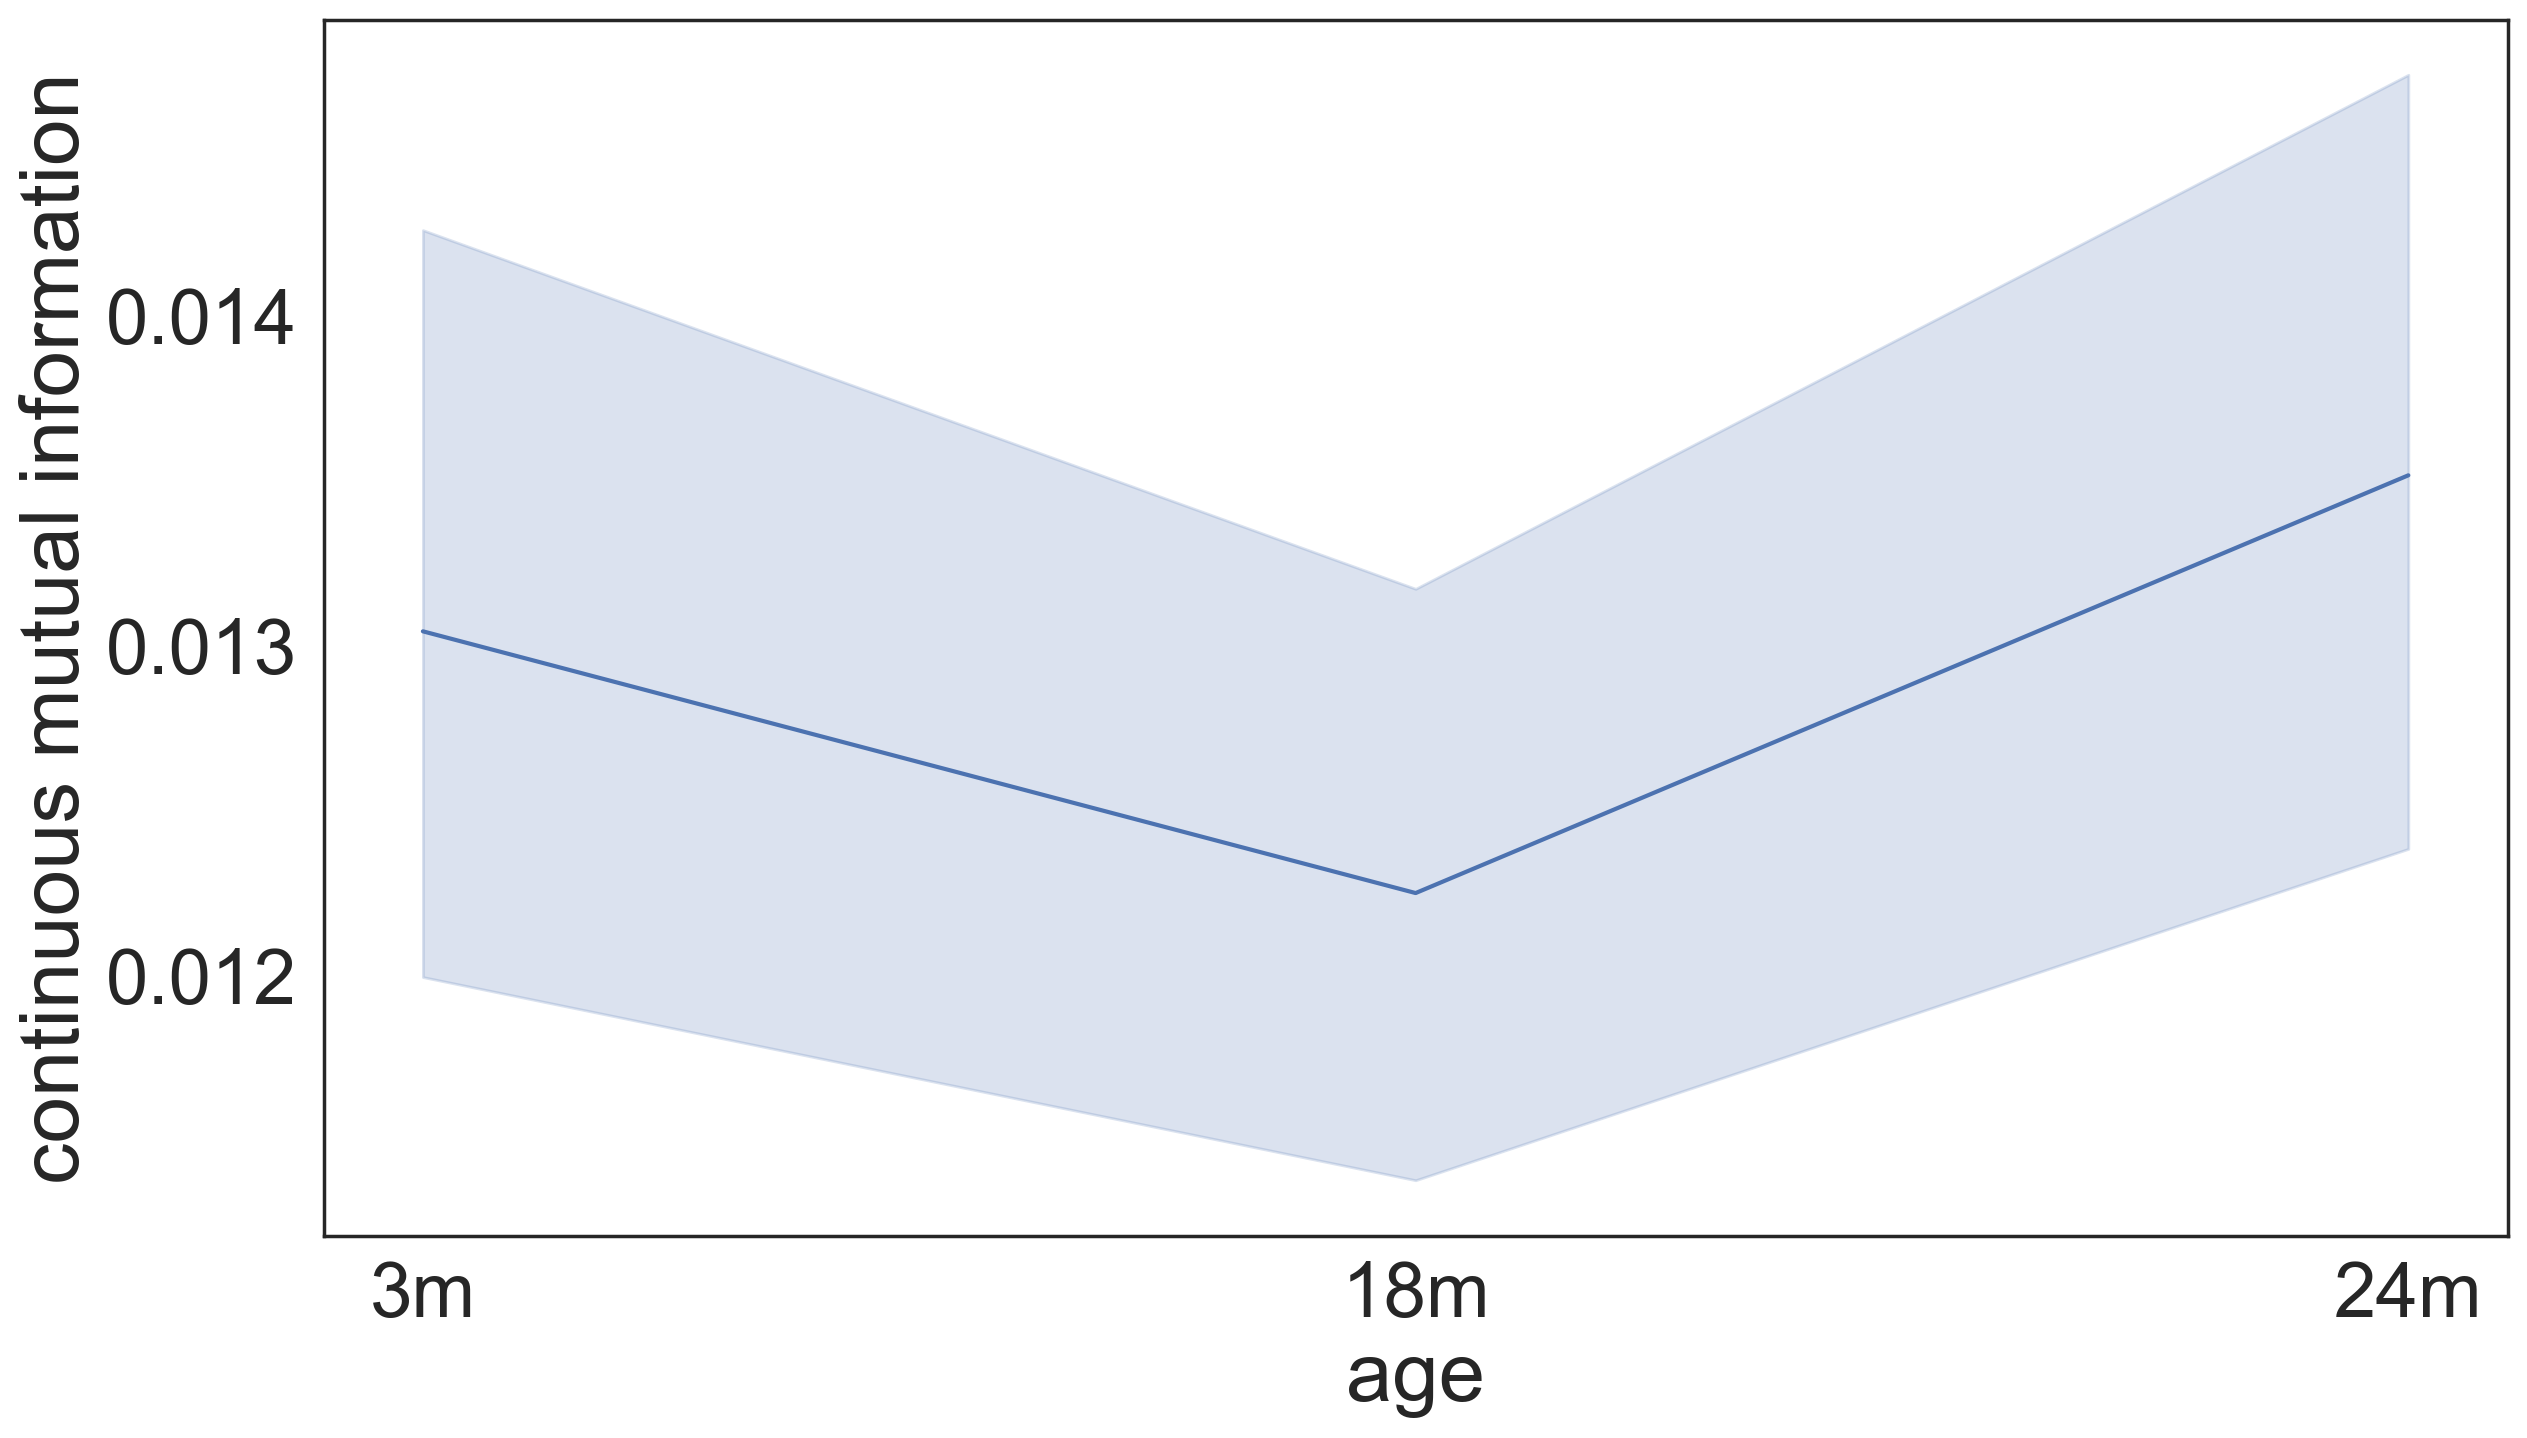

In [145]:
sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})


clean_df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
sns.lineplot(data=clean_df, x='age', y='regression_mi_score')
plt.ylabel('continuous mutual information')

# Individual TF:TG pairs mutual information

Here I am calculating mutual information between a given TF-TG pair across all cells in young, then middle-aged, then old.
Here, I am having to assume that each cell(or gene expression value) is a sample and each gene is a feature for the X matrix.
For the target vector, each cell is a sample.

The output is a list of MI values for each TF:TG gene pair. 
We obtain a list like this for each age group.

Luckily, the trend is reproducible. I have always obtained a decreasing trend although teh absolute value changes.

In [153]:
# regression_mutual_information per gene pair in one age group

mi3=[]
mi18=[]
mi24=[]
count=0
index=[]

for i,j in unique_dict.items():
    #print(type(i))
    try:

        mi3.append(continuous_mi_regression(np.array(list(age3m_df[i])).reshape(-1, 1),np.array(list(age3m_df[j])).reshape(-1, )))
        mi18.append(continuous_mi_regression(np.array(list(age18m_df[i])).reshape(-1, 1),np.array(list(age18m_df[j])).reshape(-1, )))
        mi24.append(continuous_mi_regression(np.array(list(age24m_df[i])).reshape(-1, 1),np.array(list(age24m_df[j])).reshape(-1, )))
        index.append(i+' and '+j)
    
    except KeyError:
        count=count+1
        pass

In [154]:
l = [arr.tolist() for arr in mi3]
flat_list_3m = sum(l, [])
flat_list_3m

l = [arr.tolist() for arr in mi18]
flat_list_18m = sum(l, [])
flat_list_18m

l = [arr.tolist() for arr in mi24]
flat_list_24m = sum(l, [])
flat_list_24m

[0,
 0.010167703872953737,
 0,
 0.0027471076842364717,
 0,
 0.021650153623061996,
 0.0020894760785115096,
 0.007768561611709579,
 0,
 0,
 0.0031113601010037684,
 0,
 0,
 0.039562516112575885,
 0.009983358844578571,
 0.003310655363359949,
 0,
 0,
 0,
 0,
 0.020206355221477956,
 0.01638103872835517,
 0.008627190206545343,
 0,
 0,
 0,
 0,
 0.021085428536713025,
 0.0041225953468781995,
 0,
 0.01779373909440274,
 0,
 0.0036506155389437467,
 0,
 0.024359547302061912,
 0,
 0.02362707669577091,
 0,
 0.00811502115199847,
 0.012473089500812051,
 0,
 0,
 0.022829877910653718,
 0.04129509956395605,
 0.016372635670024227,
 0.0033520195314000745,
 0.0019368664064658425,
 0,
 0,
 0.02581369441928949,
 0.011447353308448704,
 0,
 0,
 0,
 0.02122782741397744,
 0,
 0,
 0,
 0.0067113268432636985,
 0,
 0.007299175039042538,
 0.018395382436927843,
 0.019074169207136116,
 0,
 0.02525257083351473,
 0,
 0.005814303313623981,
 0.021217118216868336,
 0,
 0.015264337212629986,
 0.03989349067064474,
 0.01153161218

Text(0.5, 1.0, 'Mutual information (cmi) for individual gene pair')

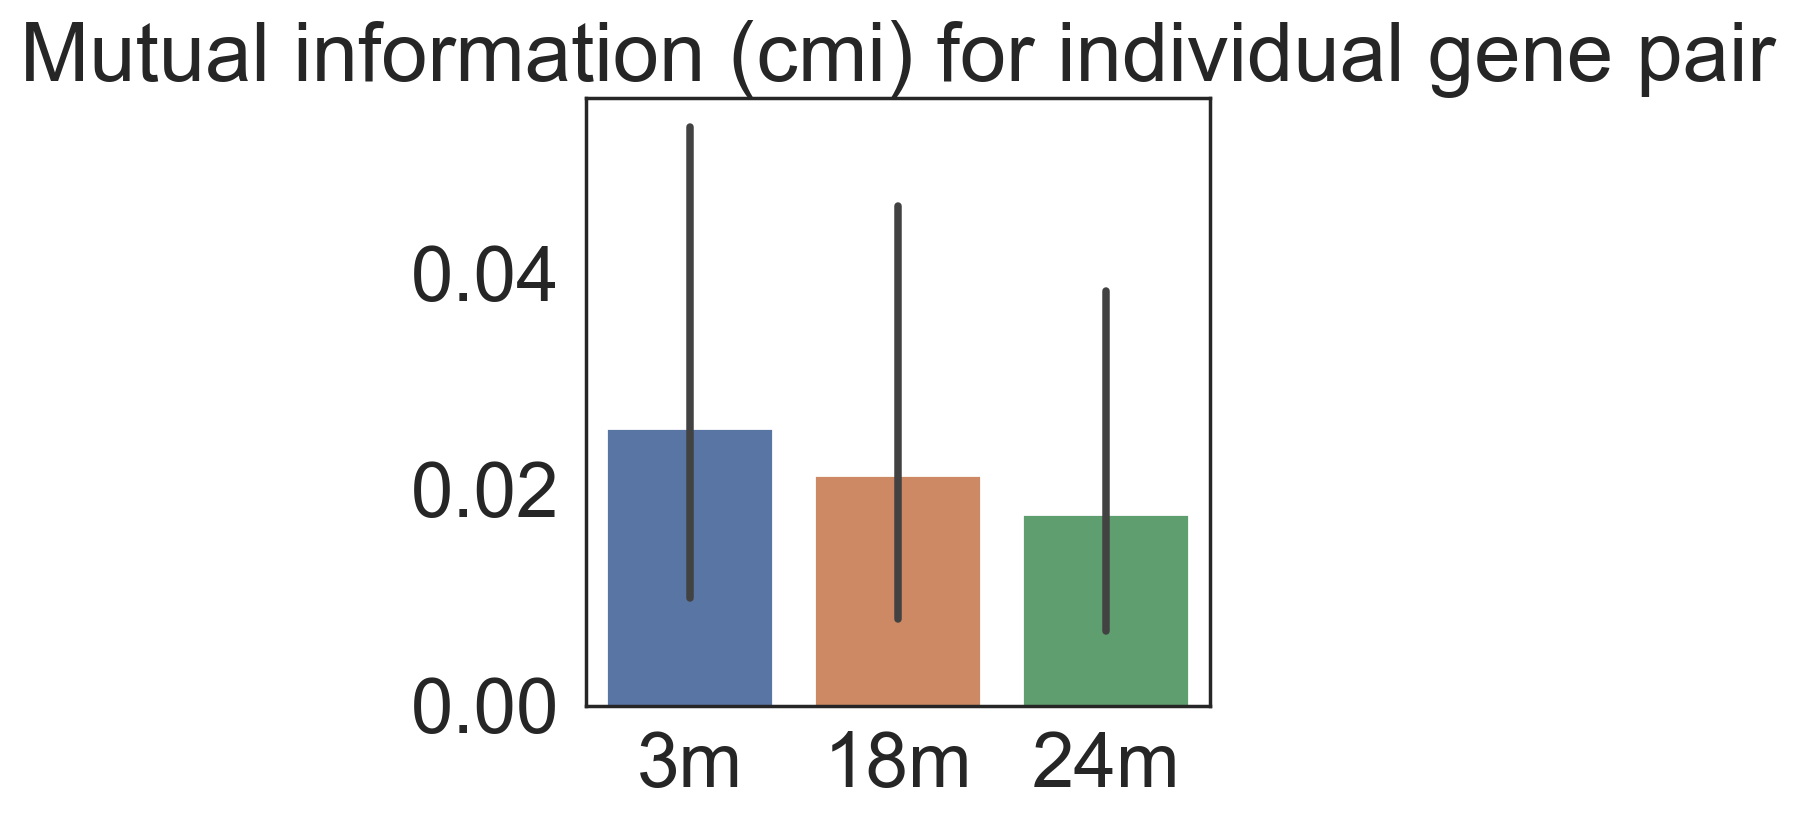

In [156]:
cmi_df=pd.DataFrame({'3m':np.array(flat_list_3m),'18m':np.array(flat_list_18m),'24m':np.array(flat_list_24m)})
cmi_df.index=index

ax = sns.barplot( data=cmi_df)
ax.set_title('Mutual information (cmi) for individual gene pair')